# Yelp Reviews Project

## Problem
In this NLP project you will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. This will be a simpler procedure than the lecture, since we will utilize the pipeline methods for more complex tasks.

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


# to allow plots to be displayed in line
%matplotlib inline
# turn off jedi to allow for faster autocomplete usage
%config Completer.use_jedi = False

# set global styling
sns.set_style('whitegrid')
sns.set_palette('YlGnBu_r', 3)

yelp = pd.read_csv('yelp.csv')

## Understanding the Data

In [2]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [3]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [4]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [5]:
# add text length column to count number of words
yelp['text length'] = yelp['text'].apply(lambda x: len(x.split()))
yelp.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,155
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,257


## Exploratory Data Analysis

Text(0.5, 1.05, 'Distribution of Text Length by Stars')

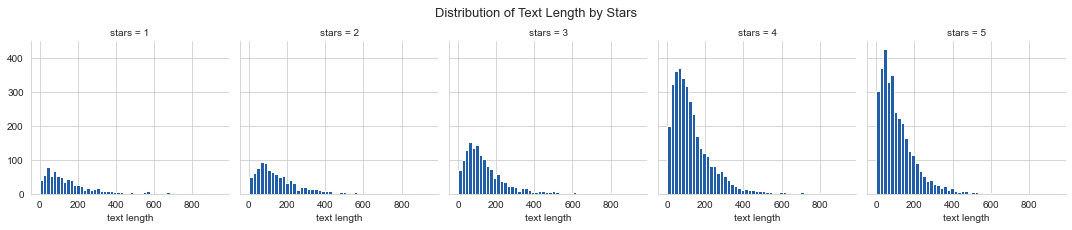

In [6]:
g = sns.FacetGrid(yelp, col='stars')
g.map(plt.hist,'text length', bins=50)
plt.suptitle('Distribution of Text Length by Stars', y=1.05, fontsize=13)

The text length of each review seems to follow the same distribution regardless of the rating. Most reviews seem to have a word count of approximately 100 words. There also seem to be significantly more 4 and 5 star reviews.

Text(0.5, 1.0, 'Count of Reviews by Stars')

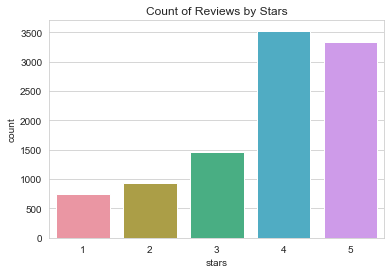

In [7]:
sns.countplot(data=yelp, x='stars')
plt.title('Count of Reviews by Stars')

This shows that there are significantly more 4 and 5 star reviews. This will likely skew the classification model.

Text(0.5, 1.0, 'Text Length vs Stars')

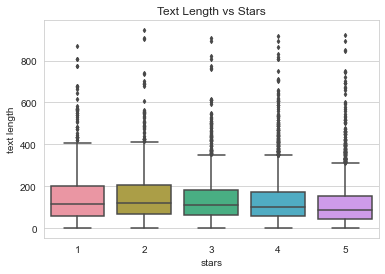

In [8]:
sns.boxplot(data=yelp, x='stars', y='text length', fliersize=3)
plt.title('Text Length vs Stars')

Based on this, text length has the same distrubtion and very similar medians for each star category. It may not be a very strong feature to select.

In [9]:
stars = yelp.groupby(['stars']).mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,153.953271
2,0.719525,1.563107,0.875944,156.435814
3,0.788501,1.306639,0.694730,140.714579
4,0.954623,1.395916,0.670448,131.174135
5,0.944261,1.381780,0.608631,114.463590


In [10]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.865362
useful,-0.743329,1.000000,0.894506,0.697506
funny,-0.944939,0.894506,1.000000,0.847204
text length,-0.865362,0.697506,0.847204,1.000000


Text(0.5, 1.0, 'Feature Correlations')

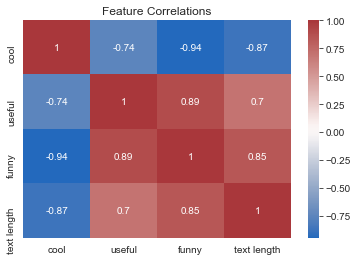

In [11]:
sns.heatmap(stars.corr(), cmap='vlag', annot=True)
plt.title('Feature Correlations')

The "funny" feature is highly correlated to "useful" and also text length. "Funny" is also highly inversely correlated to "cool".    
I don't think that these three are strong features to use in my algorithm as there seems to be no distinct relationship between them and a review's star rating.

## Data Preparation
In order to broaden the classification of reviews, I will separate the reviews into 'High Rated' and 'Low Rated' instead of predicting their star rating. 1 to 3 stars will be consider low and 4 and 5 will be considered high.

In [12]:
# converts 4 and 5 star ratings to 'high_rated'
def high_rated(yelp):
    
    if yelp['stars'] > 3:
        return 1
    else:
        return 0

# create new column called high_rated and apply function
yelp['high_rated'] = yelp.apply(high_rated, axis=1)

yelp.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length,high_rated
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,155,1
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,257,1


## Text Preprocessing

In [13]:
# indicate text column as feature and high_rated as target
X = yelp.loc[:, ['text']]
y = yelp.loc[:,'high_rated']

# instantiate vector object with sklearn's built in stopwords
cv = CountVectorizer(stop_words=stopwords.words('english'))
# fit vectorizer to text column
X = cv.fit_transform(yelp.loc[:,'text'])

## Model Training & Testing
I will train, test and evaluate this data on three models: Naive Bayes, Logistic Regression and Random Forest.

In [14]:
# perform train test split with 30% test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Naive Bayes

In [15]:
# instantiate Naive Bayes object
nb = MultinomialNB()
# fit model to training data
nb.fit(X_train, y_train)
# predict target 'high_rated' class based on test features
predictions_nb = nb.predict(X_test)

### Logistic Regression

In [16]:
# instantiate Logistic Regression object
logmodel = LogisticRegression(max_iter=1000)
# fit model to training data
logmodel.fit(X_train, y_train)
# predict target 'high_rated' class based on test features
predictions_log = logmodel.predict(X_test)

### Random Forest

In [17]:
# instantiate the random forest object with # trees = 400
rfc = RandomForestClassifier(n_estimators=300)
# fit model to training data
rfc.fit(X_train, y_train)
# predict target 'high_rated' class based on test features
predictions_rfc = rfc.predict(X_test)

## Model Evaluation
### Naive Bayes

In [18]:
print(confusion_matrix(y_test, predictions_nb))
print('\n')
print(classification_report(y_test, predictions_nb))

[[ 589  347]
 [ 205 1859]]


              precision    recall  f1-score   support

           0       0.74      0.63      0.68       936
           1       0.84      0.90      0.87      2064

    accuracy                           0.82      3000
   macro avg       0.79      0.76      0.78      3000
weighted avg       0.81      0.82      0.81      3000



### Logistic Regression

In [19]:
print(confusion_matrix(y_test, predictions_log))
print('\n')
print(classification_report(y_test, predictions_log))

[[ 635  301]
 [ 245 1819]]


              precision    recall  f1-score   support

           0       0.72      0.68      0.70       936
           1       0.86      0.88      0.87      2064

    accuracy                           0.82      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.82      0.82      0.82      3000



### Random Forest

In [20]:
print(confusion_matrix(y_test, predictions_rfc))
print('\n')
print(classification_report(y_test, predictions_rfc))

[[ 383  553]
 [  74 1990]]


              precision    recall  f1-score   support

           0       0.84      0.41      0.55       936
           1       0.78      0.96      0.86      2064

    accuracy                           0.79      3000
   macro avg       0.81      0.69      0.71      3000
weighted avg       0.80      0.79      0.77      3000



It looks like our most accurate models used to predict whether a rating is high or low were the Naive Bayes and the Logistic Regression models, both with 82% accuracy.    
For the low rating class, precision was higher for the Naive Bayes model but recall was higher using Logistic Regression.    
The results are very close but if I had to choose between both models, I would go with the Logistic Regression model where the recall for low rating reviews was higher. I would personally be more interested in a model correctly identifying low ratings of businesses in order for me to avoid but this is a personal preference of what I would use an algorithm like this for.